# Portfolio-Programmieraufgabe 4
## Strömung hinter Gittern
<!-- Lizensiert unter (CC BY 4.0), Gert Herold, Lars Bittcher, 2025 -->

Die [Lattice-Boltzmann-Methode](https://en.wikipedia.org/wiki/Lattice_Boltzmann_methods) (LBM) ist eine numerische Simulationsmethode, mit der Fluidströmungen dargestellt werden können. 
Sie besitzt einen nicht ganz trivialen theoretischen Unterbau, ist jedoch in relativ kompaktem Code implementierbar. 
Unser Ziel ist das Aufsetzen einer solchen Simulation. 
Untersucht werden soll hier ein umströmtes Hindernis, wobei wir uns der Einfachheit halber auf eine Betrachtung in 2D beschränken.

Im Ergebnis werden wir eine zeitabhängige Dichte- und Geschwindigkeitsverteilung erhalten. 
Ähnlich wie bei der Stausee-Entleerung aus HA 2 müssen dafür wiederholt Zeitschritte nacheinander berechnet werden.
Ein Zeitschritt läuft dabei immer wie folgt ab:

 1) Verschiebungsschritt
 2) Randbedingungen erfüllen
 3) Kollisionsschritt  

Was das im Detail bedeutet, erfahren Sie in den folgenden Teilaufgaben.

Zunächst werden wieder einige Module importiert, die uns den Umgang mit von Arraydaten sowie Visualisierungen erleichtern. 
**Verwenden Sie in Ihrer Lösung dieser PA keine weiteren Modul-Imports.**

In [845]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw


### 1) Umgebung vorbereiten &emsp;_(2 Punkte)_

Als erstes wollen wir unsere Simulationsumgebung definieren. 
Dazu gehören das verwendete Gitter sowie die verschiedenen Randbedingungen.
Es soll folgendes Setup realisiert werden:

![](img/LBMsetup1.svg)

Von links soll Fluid in das Rechengebiet einfließen, um ein Hindernis herum strömen und dann rechts wieder abfließen.
Nach oben/unten soll das Rechengebiet periodisch sein. 
Das bedeutet, dass alles, was oben rausgeht, unten wieder reinkommt und umgekehrt (das ist einfacher zu realisieren als es klingt).

Ein Vorteil der LBM ist, dass sie für ein sehr regelmäßiges Gitter konzipiert ist.
Wir können also einfach ein NumPy-Array hernehmen und es direkt als Rechengitter verwenden.

#### 1.1) Daten erzeugen und einlesen

Zunächst soll das Strömungshindernis definiert werden.
Das geschieht auf denkbar einfache Weise: Entweder ist an einem Punkt feste Materie (= Hindernis) oder nicht.
Nur da, wo kein Hindernis ist, kann die Strömung langfließen.
Die Größe und Form des Objekts kann prinzipiell beliebig sein.
Der beherrschbaren Rechenzeit halber sollten Sie sich jedoch in der Größe beschränken.

**Gestalten Sie ein Hindernis und programmieren Sie eine Funktion, um dieses in eine Umgebung zu setzen:**
- Erstellen Sie auf beliebige Weise (externes Zeichenprogramm, Python, ...) ein Bild namens "hindernis.gif" (Seitenlänge etwa zwischen 15 und 25 Pixel).
- Sie dürfen hier die Form selbst gestalten (am Anfang am besten nicht zu komplex).
- Erstellen Sie eine Funktion `setup_environment()` mit folgenden Eigenschaften:
  - Argumente/Parameterliste:
    - `m`, `n` : Dimensionen des Rechengitters (Zeilen, Spalten), müssen beim Funktionsaufruf angegeben werden (und sollten deutlich größer als das Bild sein).
    - `file` : Dateiname / Pfad zum Bild, das als Hindernis interpretiert werden soll, optional (default: `None`).
    - `relative_center`: Tupel mit zwei Fließkommazahlen, die später als relative Position des Objektmittelpunktes im Rechengitter interpretiert werden soll, optional (default: `(0.5, 0.25)`).
  - Die Funktion soll ein 2D-NumPy-Array mit Dimension ($m \times n$) mit Einträgen vom Typ _bool_ zurückgeben:
      - Bild-Farbwerte zwischen dunkel und hell sollen auf den nächstliegenden Wert "gerundet" werden.
      - Pixel, die ein Hindernis kennzeichen, haben den Wert 1 bzw. True, alle anderen den Wert 0 bzw. False.
      - Wenn kein Bild geladen wurde (kein Dateiname angegeben), gibt es kein Hindernis im zurückgegebenen Array.

**Wichtig:** Übermitteln Sie bei Ihrer Abgabe neben dem gelösten Notebook auch das von Ihnen erstellte Bild "hindernis.gif"!

In [846]:
def create_circle_obstacle(size=20):
    # Create a new image
    image = Image.new('L', (size, size), 255)
    draw = ImageDraw.Draw(image)
    
    # Calculate the circle parameters
    radius = size // 4
    center = (size // 2, size // 2)
    
    # Draw the circle
    draw.ellipse([
        center[0] - radius,
        center[1] - radius,
        center[0] + radius,
        center[1] + radius
    ], fill=0)
    
    # Save the image - Das Bild wird in der ursprünglichen Orientierung gespeichert
    image.save('hindernis.gif')

def setup_environment(m, n, file=None, relative_center=(0.5, 0.25)):
    
    environment = np.zeros((m, n), dtype=bool)
    
    if file is not None:
        try:
            # Bild laden
            img = Image.open(file).convert('L')
            
            # Konvertiere zu NumPy-Array und spiegele es vertikal
            img_array = np.flipud(np.array(img))
            
            # Konvertiere zu boolean array
            obstacle = img_array < 128
            
            # Berechne die Position des Hindernisses
            # Die y-Koordinate wird von unten nach oben gerechnet
            obs_height, obs_width = obstacle.shape
            center_y = int(m * (1 - relative_center[0]) - obs_height/2)
            center_x = int(n * relative_center[1] - obs_width/2)
            
            # Prüfe, ob das Hindernis in die Umgebung passt
            if (center_y >= 0 and center_y + obs_height <= m and 
                center_x >= 0 and center_x + obs_width <= n):
                # Platziere das Hindernis in der Umgebung
                environment[center_y:center_y+obs_height, 
                          center_x:center_x+obs_width] = obstacle
        
        except Exception as e:
            print(f"Fehler beim Laden des Bildes: {e}")
    
    return environment

In [847]:
# Hier sind Plausibilitäts-Tests:
assert callable(setup_environment)
assert not setup_environment(60, 180).all()

Zur Sicherheit hier noch mal ein Plot Ihrer Rechenumgebung inklusive Hindernis: Die Zeilen werden als $y$-Werte interpretiert und die Spalten als $x$-Werte. 
Die jeweiligen Koordinaten steigen mit aufsteigender Zeilen- bzw. Spaltennummer.

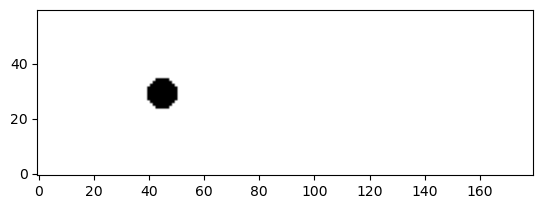

In [848]:
obstacle = setup_environment(60, 180, 'hindernis.gif')
plt.imshow(obstacle, origin='lower', cmap='binary')
plt.show()

#### 1.2) Verteilungsdichten

Die Strömung kann für jeden Gitterpunkt durch die Dichte $\rho$ und Geschwindigkeit $\vec{u}$ des Fluids an dieser Stelle beschrieben werden. 
Die eigentliche Berechnung erfolgt bei der Lattice-Boltzmann-Methode jedoch anhand von "Hilfsgrößen", den sogenannten Verteilungsdichten $f_i$.

Für jeden Punkt im 2D-Gitter sind 9 Verteilungsdichten $f_{0\ldots 8}$ definiert:

 - eine für den Punkt selbst sowie
 - jeweils eine für die Vektoren in Richtung der 8 Nachbarpunkte.

Die Richtung der Vektoren ist durch die relative Lage der Punkte im Gitter vorgegeben. 
Die Länge der Pfeile wird vom skalaren Wert der Verteilungsdichte abgeleitet.

![](img/Gitter.JPG)


Um die konkrete Verknüpfung und Berechnung kümmern wir uns später noch. 
Hier soll erst einmal nur eine Variable angelegt werden, in der die Verteilungsdichten gespeichert werden können.

**Erstellen Sie eine Funktion `init_lattice()`, die ein 2D-Array (wie das oben erstellte) übergeben bekommt und ein dazu passendes 3D-Array zurückgibt:**
  - Das Rückgabe-Array soll die gleichen ersten zwei Dimensionen wie das übergebene Array haben.
  - Die dritte Dimension habe 9 Einträge.
  - Das Array soll als Ausgangsstatus leicht "verrauschte" Einsen enthalten. Dafür werde es mit normalverteilten Zufallszahlen (Mittelwert 1, nominelle Standardabweichung 0.01) gefüllt.

In [849]:
# Hier eigenen Code schreiben ...
def init_lattice(environment):

    # Get the shape of the environment
    m, n = environment.shape
    
    # Initialize the lattice
    # The lattice has shape (m,n,9) with 9 distributions per point
    # The distributions are initialized with a small random noise
    lattice = np.random.normal(loc=1.0, scale=0.01, size=(m, n, 9))
    
    return lattice

In [850]:
# Hier sind Plausibilitäts-Tests:
test_lattice = init_lattice(obstacle)
assert test_lattice.shape[:2] == obstacle.shape
assert np.mean(test_lattice) > 0.9

### 2) Verschiebungsschritt &emsp;_(2 Punkte)_

Für die Simulation einer Strömung ist es wichtig, dass die Datenpunkte miteinander verknüpft werden, 
d.h. dass für jeden Punkt bekannt ist, welche Nachbarn er hat.
Für unser sehr einfaches regelmäßiges Gitter werden die Punkte mit ihren unmittelbaren Nachbarn verknüpft.
Pro Punkt ergeben sich damit insgesamt 9 für diesen relevante Punkte: 

 - der jeweilige Punkt selbst,
 - rechts, oben, links und unten sowie
 - die diagonal liegenden.
 

Die Richtungen werden wie folgt von 0 bis 8 durchnumeriert:

<img alt="D2Q9" src="img/e9d2q9e.svg"/>  

#### 2.2) D2Q9

**Definieren Sie ein Array `e`, das die 9 Richtungsvektoren für einen Punkt enthält:**
 - `e` soll 2 Zeilen enthalten. Jede Spalte von `e` entspricht einem Richtungsvektor.
 - Dieser enthält die "Schritte", die zum jeweiligen Nachbarn notwendig sind. Diagonale Vektoren sind dementsprechend um $\sqrt 2$ länger als die zu den horizontalen/vertikalen Nachbarn.
 - Beispiel: $e_8$ erreicht man, indem man einen Schritt in positive $x$-Richtung (+1) und einen Schritt in negative $y$-Richtung (-1) geht, also ist der entsprechende Vektor (1, -1)

In [851]:
# Hier eigenen Code schreiben ...

# Initialize the array with the vectors
e = np.array([
        [ 0,  1,  0,  -1,  0,  1, -1, -1,  1], # x-Components
        [ 0,  0,  1,   0, -1,  1,  1, -1, -1]  # y-Components
    ])

In [852]:
# Hier sind Plausibilitäts-Tests:
assert e.shape == (2, 9)
assert e[-1,-1] == -1

Das Array `e` ist für uns nun eine globale Konstante, die überall verwendet werden kann und beispielsweise an Funktionen nicht extra übergeben werden muss.

#### 2.2) Verschiebungs-Funktion 

Nun geht es an eine der Kernfunktionen im LBM-Kosmos: den  Verschiebungsschritt.
In jedem Zeitschritt werden hier die Daten in jeder der 9 Ebenen entsprechend der gerade zugeordneten Richtungen zum entsprechenden Nachbarpunkt verschoben.

![](img/verschiebung1.svg)


Bei jedem Gitterpunkt wird nun dessen Verteilungsdichte $f_{i,j,1}$ dem rechts neben ihm liegenden Punkt $f_{i,j+1,1}$ zugewiesen, er bekommt selbst die Verteilungsdichte $f_{i,j-1,1}$ seines linken Nachbarn.
Analog passiert das mit allen Richtungen.
Randpunkte sollen zunächst einfach auf der gegenüberliegenden Seite wieder angehängt werden. 
Dies entspricht netterweise der Logik der Python-Indizierung mit "0, 1, 2, ..., -2, -1".
Mit geschickter Anwendung [geeigneter NumPy-Funktionen](https://numpy.org/doc/stable/reference/generated/numpy.roll.html) ist eine entsprechende Implementierung mit sehr wenig Code und gleichzeitiger Verschiebung mehrerer Punkte möglich.

Damit dies möglichst zeiteffizient vonstatten geht, soll hier außerdem kein neues Array angelegt werden. 
Stattdessen sind alle Veränderungen direkt in einem bereits vorhandenen Array durchzuführen.

**Schreiben Sie eine Funktion `streaming()`, die den Verschiebungsschritt vornimmt.**
 - Als Argument wird ein Array mit Verteilungsdichten übergeben.
 - Für dieses werden die Verschiebungen entsprechend der mit `e` definierten Gitterschritte vorgenommen.
 - Der Inhalt des übergebenen Arrays soll direkt verändert werden. (Ein Rückgabewert der Funktion ist nicht von Interesse.)
 - Achten Sie auf korrekte Zuordnung von Zeilen / Spalten zu den Koordinaten (siehe Plot unter 1.1).

In [853]:
# Hier eigenen Code schreiben ...

"""
def streaming(f):
   # Performs the streaming step
   
   # array with 0 to 9
   # arr = np.arange(9)
   # f[:,:,arr] = np.roll(f[:,:,arr], e[0,arr], axis=1)
   # f[:,:,arr] = np.roll(f[:,:,arr], e[1,arr], axis=0)
   
   for i in range(9):
       f[:,:,i] = np.roll(np.roll(f[:,:,i], e[0,i], axis=1), e[1,i], axis=0)

"""
        
def streaming(f):
    """Performs the streaming step using vectorized operations"""
    # Kehre die y-Verschiebungen um (-e[1]) und behalte x-Verschiebungen (e[0])
    shifts = tuple(zip(-e[1], e[0]))  # (y-Verschiebung, x-Verschiebung) für alle 9 Richtungen
    f[:] = np.array([np.roll(f[:,:,i], shift=shifts[i], axis=(0, 1)) for i in range(9)]).transpose(1,2,0)


In [854]:
# Hier sind Plausibilitäts-Tests:
old_test_lattice = test_lattice.copy()
streaming(test_lattice)
assert not np.array_equal(old_test_lattice, test_lattice)

### 3) Dichte und Geschwindigkeit und Ränder  &emsp;_(2 Punkte)_

Die auf unserem Gitter vorliegenden Verteilungsdichten lassen sich durch Summation der 9 Punkte in die physikalische Größen Dichte $\rho$ und  Geschwindigkeit $\vec{u}$ (mit $x$- und $y$-Komponente) umrechnen:

$$
    \rho = \sum^{9}_{i = 1} f_{i}
$$
$$
    \vec{u} = \frac{1}{\rho} \sum^{9}_{i = 1} f_{i} \vec{e}_{i}
$$

Das kann natürlich nur funktionieren, wenn die Verteilungsdichten $f_i$ so gestaltet werden, dass sie in dieser Summation auch sinnvolle Werte ergeben.
Darum kümmern wir uns gleich noch, aber erst einmal kommt noch eine leichterer Schritt.

#### 3.1) Dichte und Geschwindigkeit

**Schreiben Sie eine Funktion `density_velocity()`, die Verteilungsdichten in Dichte und Druck umrechnet:**
 - Die Funktion bekommt ein Array mit Verteilungsdichten ($m\times n\times 9$) übergeben.
 - Sie gebe als Tupel die Arrays $\rho$ ($m\times n$) und $\vec{u}$ ($m\times n\times 2$) zurück.

In [855]:
# Hier eigenen Code schreiben ...

def density_velocity(f):
    # Calculate density
    rho = np.sum(f, axis=2)
    
    # Calculate velocity
    # Kehre die y-Komponenten um für konsistente Koordinateninterpretation
    e_modified = e.copy()
    e_modified[1] = -e_modified[1]  # Umkehrung der y-Komponenten
    e_expanded = e_modified.reshape(1, 1, 2, 9)
    
    # Expand rho for broadcasting: (m,n) -> (m,n,1,9)
    f_expanded = f.reshape(f.shape[0], f.shape[1], 1, 9)
    
    # Calculate u for all points
    u = np.sum(f_expanded * e_expanded, axis=3) / rho.reshape(rho.shape[0], rho.shape[1], 1)
    
    return rho, u

In [856]:
# Hier sind Plausibilitäts-Tests:
test_rho, test_u = density_velocity(test_lattice)
assert test_rho.shape[:2] == test_u.shape[:2] == test_lattice.shape[:2]

#### 3.2) Randbedingungen anwenden

Bisher haben wir ignoriert, dass unser Fluid nicht komplett frei herumwabern kann, sondern einigen Randbedingungen zu folgen hat.
Erstens soll von links nach rechts eine konstante gleichmäßige Strömung fließen und zweitens haben wir ja ein Hindernis mittendrin.

Für den **Einlass** (also die Punkte in der ersten Spalte links) soll gelten, dass stets Fluid mit konstanter Geschwindigkeit nachströmt.
In der [Literatur](https://arxiv.org/abs/comp-gas/9611001) findet sich hierfür z.B. folgende Berechnungsvorschrift:

$$
    f_{1} = f_3 + \frac{2}{3}\rho\, u_x 
$$
$$
    f_{5} = f_7 - \frac{1}{2} (f_2 - f_4) + \frac{1}{6}\rho\, u_x
$$
$$
    f_{8} = f_6 + \frac{1}{2} (f_2 - f_4) + \frac{1}{6}\rho\, u_x 
$$
Die Dichte berechnet sich hier mit
$$
    \rho = \frac{1}{1 - u_x}(f_2 + f_4 + f_0 + 2\,(f_3 + f_6 + f_7))
$$
Obige Formeln sollen wie gesagt _nur für den Einlass_ angewendet werden und überschreiben dort die entsprechenden Größen aus den anderen Berechnungen.

Nun zum **Auslass**: Bei korrekter Implementierung sind im vorhergehenden Verschiebungsschritt $f_3$, $f_6$ und $f_7$ von "rechts ins Feld gerückt". 
Rechts von der letzten Spalte befindet sich jedoch nichts (sinnvolles) mehr.
Um hier seltsames oder gar fehlerhaftes Verhalten zu vermeiden, überschreiben wir einfach diese Werte dieser Spalte mit denen aus $f$ in der vorletzten Spalte. 
Physikalisch gesehen entspricht dies einem zu 0 gesetzten Geschwindigkeitsgradienten aus dem Feld heraus. 

Als letztes kümmern wir uns um das **Hindernis**.
Die Materie soll komplett undurchlässig sein, das heißt, eigentlich sollte nichts hinein und auch nichts hinaus strömen.
Wir wählen einen einfachen Ansatz, um dem gerecht zu werden: 
Alles, was nach dem Verschiebungsschritt bei einem "Hindernis"-Punkt ankommt, wird postwendend zurückgeschickt, indem die Werte gegenüberliegender Richtungen für diesen Punkt ausgetauscht werden.

Hier mal ein Beispiel für einen Punkt, der zu einem Hindernis gehört:

![bounceback](img/obstacle_invert1.svg)  

Der Übersicht halber sind nur jeweils 2 der Verteilungsdichten bezeichnet.
Nach dem Verschiebungsschritt landen einige Verteilungsdichten im Hindernispunkt ($i,j$).
Um den Randbedingungen gerecht zu werden, wird nun z.B. $f_{i,j,3}$ mit $f_{i,j,1}$ überschrieben und umgekehrt, $f_{i,j,5}$ mit $f_{i,j,7}$ usw.

**Schreiben Sie eine Funktion `apply_boundaries()`, die die drei obigen Randbedingungen (Einlass, Auslass, Hindernis) implementiert:**
 - Sie bekommt 3 Argumente übergeben:
     - ein Array mit Verteilungsdichten  (Typ _float_)
     - ein (dazu passendes) Array mit dem Hindernis (Typ _bool_, Ergebnis aus Aufgabe 1.1)
     - Betrag der Strömungsgeschwindigkeit in $x$-Richtung
 - Der Inhalt des übergebenen Verteilungsdichte-Arrays soll wieder direkt verändert werden (also kein Funktions-Rückgabewert).

_Hinweis: Mit Ihrem gelernten Wissen über Array-Indizierung auf unterschiedliche Weise können Sie diese Funktion komplett ohne Schleifen realisieren. 
Der Abschnitt für die Betrachtung des Hindernisses ist dank NumPy in 1-3 Zeilen realisierbar._

In [857]:
# Hier eigenen Code schreiben ...
def apply_boundaries(f, obstacle, u_in):
    # Calculate density for Einlass
    rho = (f[:,0,2] + f[:,0,4] + f[:,0,0] + 
           2 * (f[:,0,3] + f[:,0,6] + f[:,0,7])) / (1 - u_in)
    
    f[:,0,1] = f[:,0,3] + (2/3) * rho * u_in
    f[:,0,5] = f[:,0,7] - 0.5*(f[:,0,2] - f[:,0,4]) + (1/6) * rho * u_in
    f[:,0,8] = f[:,0,6] + 0.5*(f[:,0,2] - f[:,0,4]) + (1/6) * rho * u_in
    
    # Calculate density for Auslass
    f[:,-1,3] = f[:,-2,3]
    f[:,-1,6] = f[:,-2,6]
    f[:,-1,7] = f[:,-2,7]
    
    # Obstacle bounce-back in two lines
    tmp = f[obstacle,1:9].copy()
    f[obstacle,1:9] = tmp[:,[4,5,6,7,0,1,2,3]]


In [858]:
# Hier sind Plausibilitäts-Tests:
old_test_lattice = test_lattice.copy()
apply_boundaries(test_lattice, obstacle, 0.123)
assert not np.array_equal(old_test_lattice, test_lattice)

### 4) Kollisionsschritt &emsp;_(2 Punkte)_

Um das realistische Verhalten des Fluids zu simulieren, wird ein sogenannter Kollisionsschritt eingeführt. 
Der Name bezieht sich auf die Partikel-Kollisionsprozesse im Fluid, die hier modelliert werden.
Physikalisch gesehen dämpft dieser Schritt nun die Energieweiterleitung, die durch Verschieben der Verteilungsdichten passiert ist. 
Wir verwenden hierfür die Formel

$$
    f_{i,\mathrm{dämpf}} = \rho\, \omega_i\cdot (1 + 3\, \vec{u} \cdot \vec{e}_i + \frac{9}{2} (\vec{u} \cdot \vec{e}_i)^2 - \frac{3}{2} \vec{u}\cdot\vec{u} )
$$

$$
    f_{i,\mathrm{neu}} = (1-\frac{1}{\tau})\cdot f_i + \frac{1}{\tau} \cdot f_{i,\mathrm{dämpf}}
$$

Die Relaxationszeit $\tau$ hängt von der Viskosität des Mediums ab: Je zäher, desto größer $\tau$.
Das hier verwendete Modell ist recht simpel, sodass die Simulation gerade bei geringeren Viskositäten schnell instabil werden kann.

Sie können gern mal testen, was passiert, wenn Sie für $\tau$ Werte unter 0.6 wählen.
Für schöne Ergebnisse sind Werte zwischen 0.6 und 0.8 empfehlenswert.
_(Für diejenigen, die sich bei der Betrachtung obiger Formeln über die Einheiten wundern: 
Alle Raum- und Zeitgrößen sind auf Gitter- und Zeitschrittweiten bzw. die darauf bezogene Schallgeschwindigkeit normiert, sodass diese einheitenlos sind.)_

#### 4.1) Verteilungsdichte-Gewichtungsfaktor

Je nach betrachteter Richtung wird die Veränderung der Verteilungsdichte durch den Faktor $\omega_i$ etwas anders gewichtet (entsprechend der Wahrscheinlichkeit der Partikel, sich in diese Richtung zu bewegen).

|Index $i$| $0$ |$1\ldots 4$|$5\ldots 8$|
|:-|:-:|:-:|:-:|
|**Gewicht** $\omega$|$\frac{4}{9}$|$\frac{1}{9}$|$\frac{1}{36}$|

**Definieren Sie ein 1D-Array `omega`, das die 9 Gewichtungsfaktoren in der vorgegebenen Anordnung enthält.**

In [859]:
# Hier eigenen Code schreiben ...

omega = np.array([
    4/9, 
    1/9, 1/9, 1/9, 1/9, 
    1/36, 1/36, 1/36, 1/36
])

In [860]:
# Hier sind Plausibilitäts-Tests:
assert omega.shape == (9,)

#### 4.2) Kollisions-Funktion

**Schreiben Sie eine Funktion `collision(f, tau)`, die die obige Berechnung des Kollisionsschritts implementiert.**
  
  - Sie bekommt folgende Argumente übergeben:
     - ein Array mit Verteilungsdichten  (Typ _float_)
     - den Relaxationsparameter `tau` (optional, Default-Wert 0.67)
  - Auch hier soll der Inhalt des übergebenen Verteilungsdichte-Arrays wieder direkt verändert werden, sodass kein Rückgabewert benötigt wird.

 
_Hinweise:_

  - _Die Berechnung eines oder mehrerer Skalarprodukte lässt sich auch durch elementweise Multiplikation und anschließende Summation (über die korrekte Dimension!) erreichen._
  - _Schauen Sie sich in Ruhe noch mal die Broadcasting-Regeln an. Sie könnten hier sehr nützlich sein. Schleifen sind nicht notwendig._
  - _Für eine effiziente Implementierung ist es mitunter hilfreich, die Terme in den Formeln etwas umzustellen._
  - _Die Berechnung der Dichte und Geschwindigkeit haben Sie schon oben als Funktion implementiert, die Sie hier weiterverwenden können._

In [861]:
'''
def collision(f, tau=0.67):
    
    # Calculate density and velocity
    rho, u = density_velocity(f)  # Diese Funktion wurde bereits angepasst
    
    # Calculate u·u for all points
    u_sqr = np.sum(u*u, axis=2)
    
    # Expand e for broadcasting and modify y-components
    e_modified = e.copy()
    e_modified[1] = -e_modified[1]  # Umkehrung der y-Komponenten
    e_expanded = e_modified.reshape(1, 1, 2, 9)
    
    # Calculate u·e for all points and directions
    u_expanded = u.reshape(u.shape[0], u.shape[1], 2, 1)
    u_e = np.sum(u_expanded * e_expanded, axis=2)
    
    # Calculate equilibrium distributions
    # Expand rho and omega for broadcasting
    rho_expanded = rho.reshape(rho.shape[0], rho.shape[1], 1)
    
    f_eq = (rho_expanded * omega * (1 + 3*u_e + 4.5*u_e*u_e - 1.5*u_sqr.reshape(u_sqr.shape[0], u_sqr.shape[1], 1)))
    
    # Update distributions
    f[:] = (1 - 1/tau) * f + (1/tau) * f_eq
'''
    
def collision(f, tau=0.67):
    rho, u = density_velocity(f)
    
    # Berechne u_ei (Skalarprodukt)
    u_ei = 3.0 * (u[...,0:1] * e[0] + u[...,1:2] * e[1])
    
    # u²
    u_sq = 1.5 * np.sum(u**2, axis=2)[...,None]
    
    # f_equilibrium berechnen
    f_eq = rho[...,None] * omega * (1.0 + u_ei + 4.5 * u_ei**2 - u_sq)
    
    # Update f
    f[:] = f * (1.0 - 1.0/tau) + f_eq/tau

In [862]:
# Hier sind Plausibilitäts-Tests:
old_test_lattice = test_lattice.copy()
collision(test_lattice)
assert not np.array_equal(old_test_lattice, test_lattice)

Wenn Sie diesen Schritt implementiert haben, klopfen Sie sich auf die Schulter und trinken Sie erst einmal einen Kaffee oder ein anderes Heißgetränk Ihrer Wahl.
Dann starten Sie mit dem letzten Aufgabenteil.

### 5) Simulation &emsp;_(2 Punkte)_

Jetzt wird's ernst; die Zeit läuft bzw. soll laufen.
Wir haben das unten schon mal für Sie vorbereitet. 

#### 5.1) Run!
**Ergänzen Sie die Funktion `run_LBM()` um die im [Docstring](https://peps.python.org/pep-0257/) angegebenen noch fehlenden Funktionalitäten und führen Sie sie aus.**

- Starten Sie zunächst mit einer geringen Anzahl an Zeitschritten und testen Sie, ob die Simulation erfolgreich ist.
- Wenn es gut läuft, probieren Sie gern mal 10000 Zeitschritte und mehr und werten das sich entwickelnde Strömungsfeld aus.
- Sie können die Parameter zwischen den Kommentaren "Parameter ab hier" und "Parameter bis hier" sowie in der letzten Zeile der Zelle gern variieren.
- Achten Sie darauf, dass die Rechenzeit maximal im Bereich weniger Minuten liegt und die Simulation stabil bleibt (die Zahlen also nicht ins Unendliche divergieren).

In [863]:
def run_LBM(timesteps, snapshot_interval=0, export_images=''):
    # Parameter ab hier
    m = 60
    n = 180
    file = 'hindernis.gif'
    center = (0.5,0.2)
    
    tau = 0.8 # Initial 0.8
    ux = 0.11 # Initial 0.2
    # Parameter bis hier
    
    # Initialisierung
    obs = setup_environment(m, n, file, center)
    f = init_lattice(obs)
    
    # Wenn Snapshots gewünscht, importiere matplotlib
    if snapshot_interval > 0:
        import matplotlib.pyplot as plt
    
    for t in range(timesteps):
        # Verschiebung
        streaming(f)
        
        # Randbedingungen
        apply_boundaries(f, obs, ux)
        
        # Kollision
        collision(f, tau)
        
        
        # Output snapshot if desired
        if snapshot_interval > 0 and t % snapshot_interval == 0:
            # Calculate current density and velocity
            rho, u = density_velocity(f)
            
            # Text output
            print(f"Timestep {t}:")
            print(f"  Mean distribution density: {np.mean(f):.6f}")
            print(f"  Minimum distribution density: {np.min(f):.6f}")
            print(f"  Maximum distribution density: {np.max(f):.6f}")
            
            # Image output if desired
            if export_images:
                # Calculate velocity magnitude
                velocity_magnitude = np.sqrt(np.sum(u**2, axis=2))
                
                plt.figure(figsize=(12,4))
                plt.imshow(velocity_magnitude,origin='lower', cmap='viridis')
                plt.colorbar(label='Velocity magnitude')
                
                
                # Overlay obstacle
                plt.imshow(obs, alpha=0.3,origin='lower', cmap='binary')
                
                plt.title(f'Timestep {t}')
                plt.savefig(f'{export_images}_{t}.png')
                plt.close()
                
        rho, u = density_velocity(f)
        
        # if np.isnan(rho).any() or np.isnan(u).any() or (rho < 0).any():
            # print(f"Instabilität erkannt bei Timestep {t}! Abbruch der Simulation.")
            # break
            
    return rho, u, obs

#### 5.2) Show!

**Plotten Sie das Ergebnis $|\vec{u}|$ (`u_abs`) als 2D-Bild für alle am Ende erhaltenen Geschwindigkeiten aus Ihrer obigen Simulation.**
  
 - Achten Sie auf korrekte Ausrichtung der Achsen und eine geeignete Farbskalierung.
 - Das Hindernis soll an der korrekten Position über der Strömungsvisualisierung dargestellt sein und deutlich erkennbar sein.
 - Erstellen Sie eine Farbskala neben dem Plot zur Zuordung der Werte.
 - Sie können in zusätzlichen Plots gern weitere Größen wie z.B. die Wirbelstärke visualisieren.

/var/folders/2x/cv375qk95wg5kxg56x6mt4mw0000gn/T/ipykernel_87987/745573641.py:39: RuntimeWarning: overflow encountered in multiply
  f_eq = rho[...,None] * omega * (1.0 + u_ei + 4.5 * u_ei**2 - u_sq)
/var/folders/2x/cv375qk95wg5kxg56x6mt4mw0000gn/T/ipykernel_87987/745573641.py:42: RuntimeWarning: overflow encountered in divide
  f[:] = f * (1.0 - 1.0/tau) + f_eq/tau
/var/folders/2x/cv375qk95wg5kxg56x6mt4mw0000gn/T/ipykernel_87987/2079322863.py:17: RuntimeWarning: invalid value encountered in multiply
  u = np.sum(f_expanded * e_expanded, axis=3) / rho.reshape(rho.shape[0], rho.shape[1], 1)
/var/folders/2x/cv375qk95wg5kxg56x6mt4mw0000gn/T/ipykernel_87987/2079322863.py:17: RuntimeWarning: invalid value encountered in divide
  u = np.sum(f_expanded * e_expanded, axis=3) / rho.reshape(rho.shape[0], rho.shape[1], 1)
/var/folders/2x/cv375qk95wg5kxg56x6mt4mw0000gn/T/ipykernel_87987/745573641.py:33: RuntimeWarning: invalid value encountered in multiply
  u_ei = 3.0 * (u[...,0:1] * e[0] + u[...

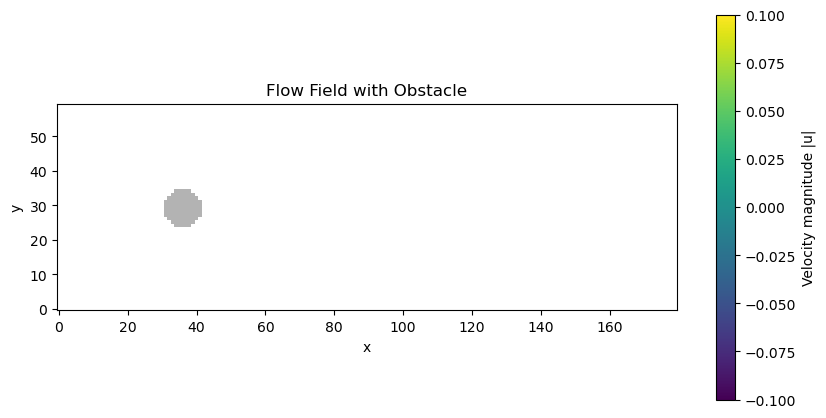

In [864]:
plt.figure(1,(10,5))
# Hier eigenen Code schreiben ...

# Run the LBM simulation
rho, u, obstacle = run_LBM(1000)

# rho, u, obstacle = run_LBM(70, 5, 'snap')
# Calculate velocity magnitude
u_abs = np.sqrt(np.sum(u**2, axis=2))

# Create main velocity plot
plt.imshow(u_abs, origin='lower', cmap='viridis')
plt.colorbar(label='Velocity magnitude |u|')

# Overlay obstacle
plt.imshow(obstacle, origin='lower', cmap='binary', alpha=0.3)

# Add labels and title
plt.xlabel('x')
plt.ylabel('y')
plt.title('Flow Field with Obstacle')

plt.show()

In [865]:
# Hier sind noch einige letzte Plausibilitäts-Tests:
rho_test, u_test, obstacle_test = run_LBM(3)
assert rho_test.shape[:2] == u_test.shape[:2] == obstacle_test.shape[:2]
assert len(u_test.shape) > len(rho_test.shape)
assert (rho_test > 0).all
assert (u_abs > 0).all

In [866]:
#### Wenn Sie ein interessantes Ergebnis erhalten haben, dürfen Sie ein Bild oder eine Animation Ihres Strömungsfelds gern im Kurs-Forum teilen.